In [1]:
import mlflow
import pandas as pd
import pickle
from pathlib import Path
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit 
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sbn
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from mlflow.models.signature import infer_signature

# Multiple outputs per notebook cell
%config InteractiveShell.ast_node_interactivity = 'all'

# random_state for different processes
RANDOM_STATE = 221

In [2]:
def num_rows_horizon(df, timeframe='7day'):
    ''' 
    Input: Dataframe, Timeframe (in to_timedelta format)
    Output: Outputs number of rows in dataframe to reach timeframe
    '''
    return len(df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('7day'))])

# validate test
def trainval_test_split(df):
    final_test = df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('8day'))]
    train_validate = df.loc[df['day'] < (df['day'].max() - pd.to_timedelta('7day'))]

    return train_validate, final_test

# train validate
def load_train_test(df, drop_index=True):
    ''' 
    Input: Dataframe from features prep
    Output: Data prepared for hyperparameter search
    '''
    X = (df.drop(columns=['load_actual', 'country', 'day']) 
           .dropna() # remove NAs from creating lagged variables
           .reset_index()
           )
    if drop_index:
        X = X.drop(columns='utc_timestamp')
     
    y = (df.reset_index(drop=True)[['load_actual']])
    
    return X, y


### Load Data
- Creating train/test and validation sets, then ensure windows are correct

In [3]:
cd = Path.cwd()
data_dir = str(cd.parents[1])
upsampled = data_dir + '/datasets/country_energy/load_wthr_downsample.pickle'
downsampled = data_dir + '/datasets/country_energy/load_wthr_upsample.pickle'

# Xu - upsampled
with open(upsampled, 'rb') as f:
    Xu = pickle.load(f)

# Xd - downsampled
with open(downsampled, 'rb') as f:
    Xd = pickle.load(f)

# Create test/train and validation set. Ensure dates are correct
final_test_u = Xu.loc[Xu['day'] > (Xu['day'].max() - pd.to_timedelta('8day'))] # 8 days is selected because last day 2019-4-30 has 0 hours
Xu_check = Xu.loc[Xu['day'] < (Xu['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_u.index.min()}, max date: {final_test_u.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xu_check.index.min()}, max date: {Xu_check.index.max()}')

final_test_d = Xd.loc[Xd['day'] > (Xd['day'].max() - pd.to_timedelta('8day'))]
Xd_check = Xd.loc[Xd['day'] < (Xd['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_d.index.min()}, max date: {final_test_d.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xd_check.index.min()}, max date: {Xd_check.index.max()}')

Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:45:00+00:00
Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:00:00+00:00


Prepare Data for Model Training

Objective Function (LightGBM) -- consider adding timing param within mlflow (assuming mlflow doesn't already track that)

In [3]:
def objective(params, x, y, n_splits=10): # n_splits=10, params, # adjust x, y being the upsample and downsample datasets
#def objective():
    # Time Series splits for cross validation 
    num_rows_horizon = len(x.loc[x['day'] > (x['day'].max() - pd.to_timedelta('7day'))])
    ts_cv = TimeSeriesSplit(n_splits=10, test_size=num_rows_horizon) 
    folds = []
    fold_mae = []
    fold_mape = []

    # drop unneeded day variable
    x = x.drop(columns='day')

    # start run with ml flow, record metrics
    # try this: mlflow.autolog()
    with mlflow.start_run(nested=False): #nested=True
        # params = {
        # # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # adjust
        # 'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        # 'num_leaves': trial.suggest_int('num_leaves', 31, 511), # adjust
        # 'max_depth': trial.suggest_int('max_depth', 3, 9), # adjust if overfit
        # # 'subsample': trial.suggest_float('subsample', 0.5, 1), # research
        # # 'colsample_bytree': trial.suggest-float('colsample_bytree', 0.7, 1),
        # # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        # # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
        # }
        
        mlflow.log_params(params)

        # early stoppin gcallback
        early_stopping = lgbm.early_stopping(5) # verbose=False 
        
        # Dataset splits for nested cross-validation
        for i, (train_idx, test_idx) in enumerate(ts_cv.split(x)):
            X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            
            # model, model fit, and predictions
                # partial w/ params?
            model = lgbm.LGBMRegressor(
                **params, 
                random_state=RANDOM_STATE, 
                n_jobs=-1,
                callbacks = [early_stopping]
                # num_threads, # set to number of real cpu cores available
                # for distribtued training https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html
                #callbacks = [early_stopping(5)],
 # early_stopping_min_delta 
                )  # path_smooth 
            model.fit(X_train, y_train) # has no attribute append
            y_pred = model.predict(X_test)

            # loss metrics
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            # record loss metrics for mean
            folds.append(i+1)
            fold_mae.append(mae)
            fold_mape.append(mape)
    
        # log mean / std of folds
        avg_mae = np.mean(fold_mae)
        std_mae = np.std(fold_mae)
        avg_mape = np.mean(fold_mape)
        std_mape = np.std(fold_mape)
        mlflow.log_metrics({
            'avg_mae': avg_mae,
            'std_mae': std_mae,
            'avg_mape': avg_mape,
            'std_mape': std_mape,   
        })

        # fold level results
        tbl = pd.DataFrame({'folds': folds, 
                            'mae_per_fold': fold_mae,
                            "mape_per_fold": fold_mape}).round(4)
        mlflow.log_table(data=tbl, artifact_file='results_per_fold.json')
        
    mlflow.end_run()
    return {'avg_mae': avg_mae, 'std_mae': std_mae, 'avg_mape': avg_mape, 'std_mape': std_mape}
    #return avg_mape



Model Training and Hyperparameter Selection

In [ ]:
# Prep data
# Xd_features = (Xd.loc[Xd['country'] == 'BE']
#                .drop(columns=['load_actual', 'country']) # hdd cdd
#                .reset_index(drop=True)) 

# yd = (Xd.loc[Xd.country == 'BE']
#       .reset_index(drop=True)[['load_actual']])
    ### automate to work across countries

#### Seek to do param searhc in parallel
# Prelim Params
# params = {
#     # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # adjust
#     'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
#     'num_leaves': trial.suggest_int('num_leaves', 31, 511), # adjust
#     'max_depth': trial.suggest_int('max_depth', 3, 9), # adjust if overfit
#     # 'subsample': trial.suggest_float('subsample', 0.5, 1), # research
#     # 'colsample_bytree': trial.suggest-float('colsample_bytree', 0.7, 1),
#     # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
#     # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
# }

# simplified params for testing
# from skopt import BayesSearchCV
# from skopt.space import Real#, Integer

params = {'learning_rate': [0.001],
          'reg_alpha': [0.5]}

mlflow.end_run() # cancel any existing flows
if __name__ == "__main__":

    mlflow.set_experiment("Time Series CV Parameter Tuning")
    
    # test = BayesSearchCV(
    #     objective, # will this allow me to pass params?
    #     **params,
    #     cv=1, # default 3 perhaps set to time series split
    #     n_iter=10, # consider raising this for more 'finely tuned' (or overfit)
    #     random_state = 226,
    #     n_jobs=-1
    # )

    # results = test.fit(Xd_features, yd, 
    #                    #eval_metric = 'mae', 
    #                    #eval_set = [(X_test, y_test)],
    #                    early_stopping_rounds = 5)
  
    start = time.time() # mlflow may replace this
    results = objective(params, Xd_features, yd) 
    end = round(time.time() - start, 2)
    print(f"\n\nParams = {params}: MAE = {results['avg_mae']:.2f}, MAPE = {results['avg_mape']:.2%}, Total Runtime = {end}")    


    # for params in generate_parameter_combinations(param_grid):  # Implement your grid generator
    #     with mlflow.start_run():
    #         results = objective(params, X, y)
    #         print(f"Tested {params}: MAE={results['avg_mae']:.2f}, MAPE={results['avg_mape']:.2%}")    

Pre-Optimization Preparation

In [ ]:
# nrow = num_rows_horizon(Xd, timeframe='7day')

# # for data in [Xd, Xu]:
# X_train, y_train = country_train_test(Xd)

In [42]:

# Nested timeseries split for cross validation
ts_cv = TimeSeriesSplit(n_splits=10, test_size=nrow)

# Model and callbacks
early_stopping = lgbm.early_stopping(5)
model = lgbm.LGBMRegressor(
                random_state=RANDOM_STATE, 
                n_jobs=-1,
                callbacks = [early_stopping]
                )

Hyperparameter optimization, logging with Mlflow

In [24]:
### Unsure what the this does, but will try it
# from mlflow.models.signature import infer_signature

def optimization_logs(params, opt_model, importance_plot, test_plot, bayes_opt, final_mape, end, country):
    # params
    mlflow.log_params(params)
    # best params in training
    mlflow.log_table(opt_model.best_params_, artifact_file=f'{country}_best_params.json')
    # variable importance plot
    mlflow.log_figure(importance_plot.figure, f'{country}_variable_importance.png')
    # predicted versus actuals
    mlflow.log_figure(test_plot, 'predicted_vs_actuals.png') 
    # metrics
    mlflow.log_metrics({
                    'optimization_training_time': end,
                    'best_training_mape': abs(bayes_opt.best_score_),
                    'final_test_mape': final_mape,
                })
    # Save model
    mlflow.sklearn.log_model(sk_model=opt_model.best_estimator_, 
                              #registered_model_name=f"./{country}_best_model",
                              artifact_path=f"{country}_best_model"
                              )
    # consider trying model signature
    

# ... Seeking best set of models?
def hyperparam_opt(dataset, country, iterations=25, nested_windows=10):
    with mlflow.start_run(nested=True): 
        # Split into training/validation and test sets
        train, test = trainval_test_split(dataset)
        # Prepare Training Data
        nrow = num_rows_horizon(dataset, timeframe='7day')
        X_train, y_train = load_train_test(train)

        # Nested timeseries split for cross validation
        ts_cv = TimeSeriesSplit(n_splits=nested_windows, test_size=nrow)

        # Model and callbacks
        early_stopping = lgbm.early_stopping(5)
        model = lgbm.LGBMRegressor(
                        random_state=RANDOM_STATE, 
                        n_jobs=-1,
                        callbacks = [early_stopping],
                        verbosity=-1
                        )
        
        # Parameter set / ranges
        params = {
            'learning_rate': Real(0.001, 2, 'uniform'),
            'reg_alpha': Real(0, 1, 'uniform'),
            'num_leaves': Integer(20, 500, 'uniform'), # adjust
            'max_depth': Integer(3, 9, 'uniform'), # adjust if overfit
            #'subsample': Real(0.5, 1, 'uniform'), # research
            'colsample_bytree': Real(0.7, 1, 'uniform'),
            'reg_alpha': Real(0, 1, 'uniform'),
            'min_data_in_leaf': Integer(20, 100, 'uniform')
        } # reduce training time
        # path_smooth

        # BayesSearch of optimal params
        bayes_opt = BayesSearchCV(
            model,
            params,
            cv=ts_cv,
            n_iter=iterations, # 50, 100
            scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
            n_jobs=-1,
            random_state=RANDOM_STATE,
            return_train_score=True,
            optimizer_kwargs = {'base_estimator': 'RF'},
        )

        # Run and time bayesian optimization of params
        start = time.time()
        opt_model = bayes_opt.fit(X_train, y_train)
        end = round(time.time() - start, 2)

        # Variable Importance Plot
        importance_plot = lgbm.plot_importance(bayes_opt.best_estimator_, 
                                               figsize=(8,5), 
                                               title=f'{country} Variable Importance')
        
        # Get predictions of optimal set of params for final test set
        X_test, y_test = load_train_test(test, drop_index=False)
        y_pred = opt_model.best_estimator_.predict(X_test.drop(columns='utc_timestamp'))
        y_test = np.reshape(y_test, (len(y_test),))
        final_mape = mean_absolute_percentage_error(y_test, y_pred)  

        # Time Series plot of Predicted Vs Actuals
        plot_dt = pd.DataFrame({'Day': X_test['utc_timestamp'],
                                'actual': np.reshape(y_test, (len(y_test),)), 
                                'predicted': y_pred})

        test_plot = plt.figure(figsize=(10,5))
        _ = sbn.lineplot(data=plot_dt, 
                        x='Day', 
                        y='actual', 
                        color='red', 
                        label='Actuals')
        _ = sbn.lineplot(data=plot_dt, 
                        x='Day', 
                        y='predicted', 
                        color='grey', 
                        label='Predicted')
        _ = plt.ylabel('Load (MW)')
        _ = plt.title(f'Predicted Vs. Actual Load for {country}') # 'For {Country}'

        # Log params, result metrics, and visualizations
        optimization_logs(params, 
                          opt_model, 
                          importance_plot, 
                          test_plot, 
                          bayes_opt, 
                          final_mape, 
                          end, 
                          country)

In [17]:

# datasets = [Xd, Xu]
# dataset_names = ['Xd', 'Xu']
# Track Optimized Country Level models, metrics, and visualizations
def automated_forecast(datasets, dataset_names, iter_per_model=25, nested_windows=10, experiment_name='No experiment name given'):
    '''
    datasets
    dataset_names
    iter_per_model
    nested_windows
    experiment_name
    '''
    if __name__ == "__main__":
    #try:
        mlflow.set_tracking_uri("http://127.0.0.1:5000")
        mlflow.set_experiment(experiment_name)

        for name, data in zip(dataset_names, datasets):
            # does this need to be nested? 
            mlflow.start_run(#nested=True, # with mlflow.start_run(run_name=run_name) as run
                             run_name=f'{name} Country Energy Forcast')

            # Group data, begin process for each group in data
            country_data = data.groupby('country')

            for country, data in country_data: 
                with mlflow.start_run(nested=True, run_name=f"Country: {country}"): # with mlflow.start_run(run_name=run_name) as run
                    # Begin optimization process for country level data
                    # Definitely need run name here when this process is kicked off (country name)
                    hyperparam_opt(data, country, iterations=iter_per_model, nested_windows=nested_windows) # consider including country in the optimization for titles and metric logging  
            
            # End run for that dataset
            mlflow.end_run()
    
        
    # end mlflow run if an exception occurs
    # except:
    #     mlflow.end_run()


In [ ]:
# Version 2 (country -> datasets)
# datasets = [Xd, Xu]
# dataset_names = ['Xd', 'Xu']
# Track Optimized Country Level models, metrics, and visualizations
def automated_forecast(data, iter_per_model=25, nested_windows=10, experiment_name='No experiment name given'):
    '''
    datasets
    dataset_names
    iter_per_model
    nested_windows
    experiment_name
    '''
    if __name__ == "__main__":
        mlflow.set_tracking_uri("http://127.0.0.1:5000")
        mlflow.set_experiment(experiment_name)
        
        # Group data, begin process for each group in data
        country_data = data.groupby('country')

        for country, data in country_data: 
            with mlflow.start_run(#nested=True, 
                                  run_name=f"Country: {country}"): # with mlflow.start_run(run_name=run_name) as run
                # Begin optimization process for country level data
                # Definitely need run name here when this process is kicked off (country name)

                hyperparam_opt(data, country, iterations=iter_per_model, nested_windows=nested_windows)

        # End run for that dataset
        mlflow.end_run()


2025/03/01 19:51:42 INFO mlflow.tracking.fluent: Experiment with name 'Upsample only' does not exist. Creating a new experiment.
2025/03/01 19:52:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bouncy-rat-707 at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/cd636871fd074544a4506fed838c7876
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918
🏃 View run Country: AT at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/f8b1f281d53e4b65b6e7c41edd8df97d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918


2025/03/01 19:53:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run grandiose-shrike-183 at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/fc63d1d3670647609d4303356fa27fa8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918
🏃 View run Country: BE at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/0a93ff905bc0469a96df520d3d2d7ddd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918


2025/03/01 19:54:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run calm-gnat-244 at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/67029a9c10ed490fb97818ff08af95b3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918
🏃 View run Country: DE at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/996faa4cf65144a1a1ca305e94c5f4a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918


2025/03/01 19:54:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run secretive-midge-526 at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/defa9de4aee647a18de10383376293af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918
🏃 View run Country: HU at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/afb001db52254d2c9a38026035940d37
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918


2025/03/01 19:55:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run silent-elk-133 at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/69574f9f5b514e608d97bfc6633ed7f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918
🏃 View run Country: LU at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/51feeb7035064612a438b4828d4db5b7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918


2025/03/01 19:56:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run clumsy-squid-519 at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/1c2d2d4853614e00a9dace2337e9d24c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918
🏃 View run Country: NL at: http://127.0.0.1:5000/#/experiments/128770794700257918/runs/a70689731b5043eeb1b41eea2cd96b86
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/128770794700257918


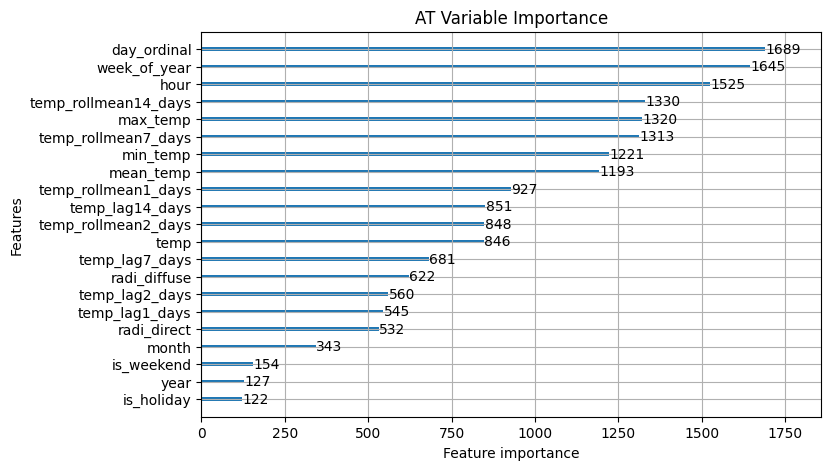

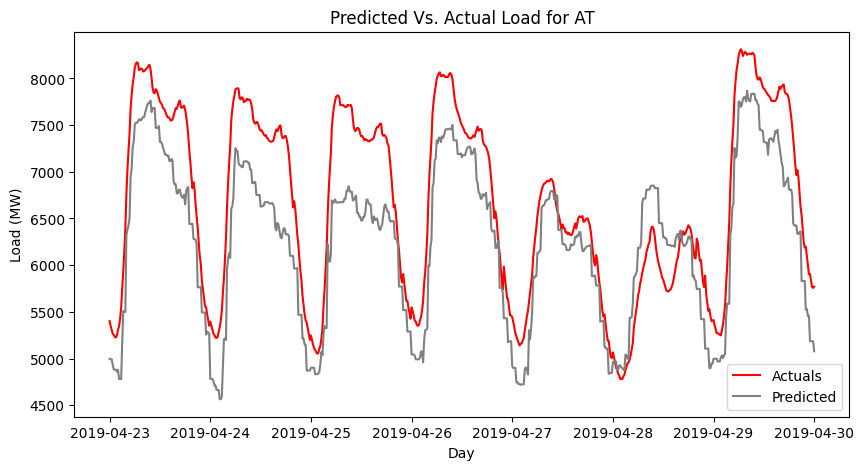

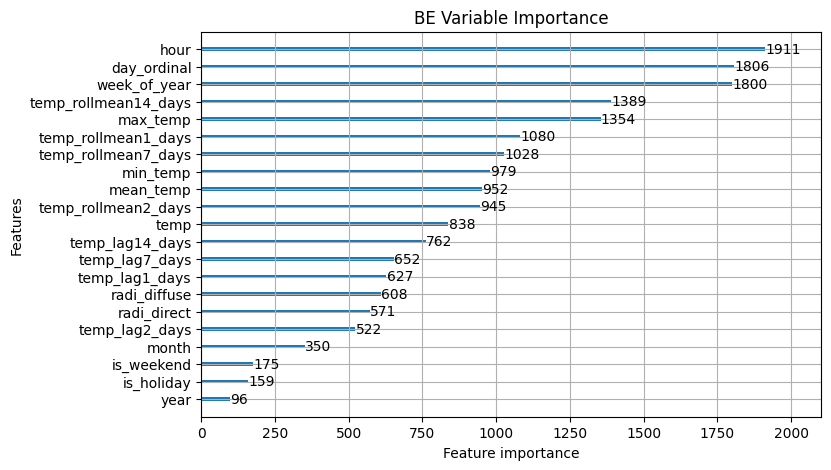

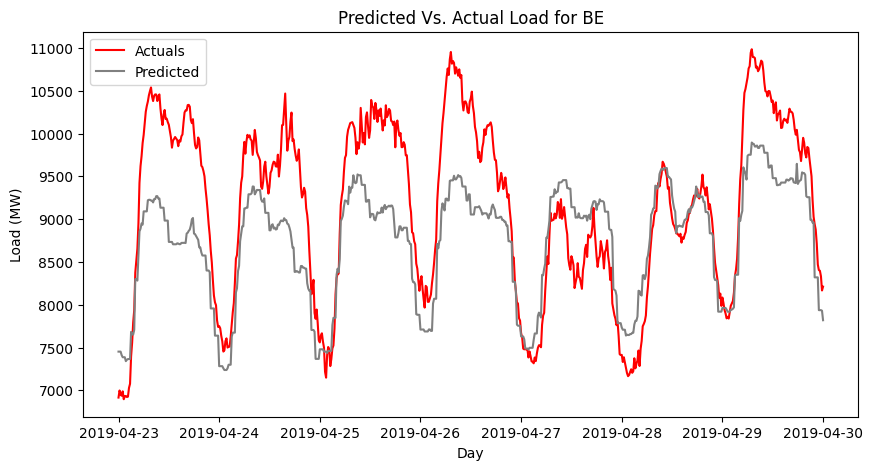

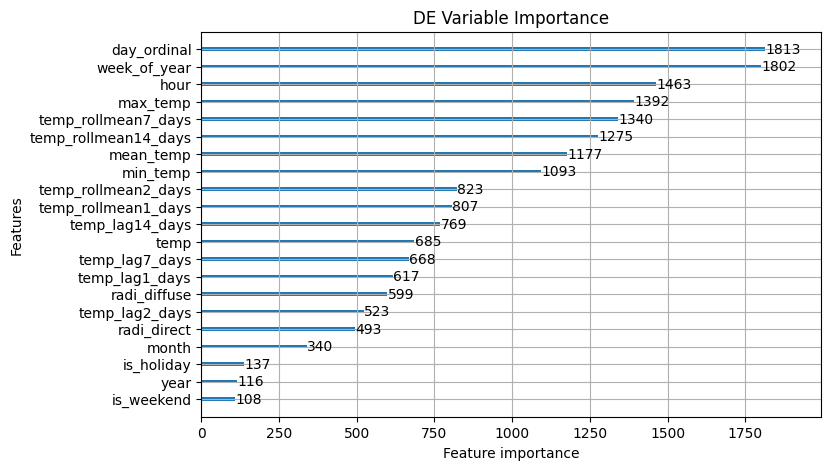

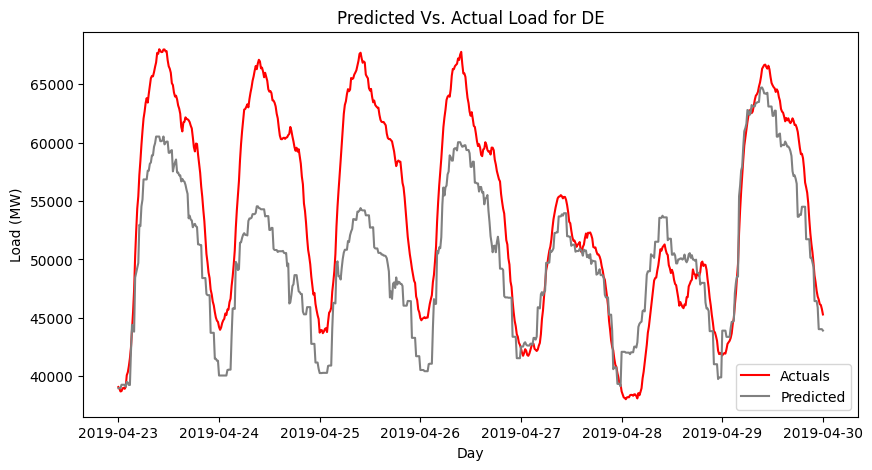

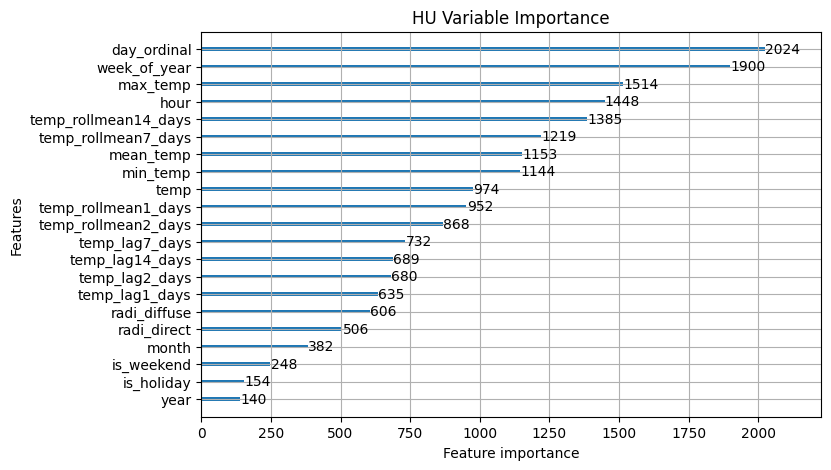

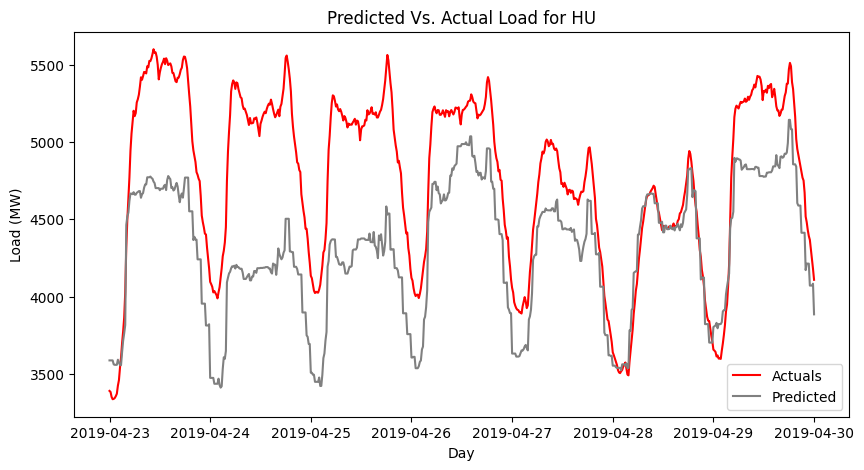

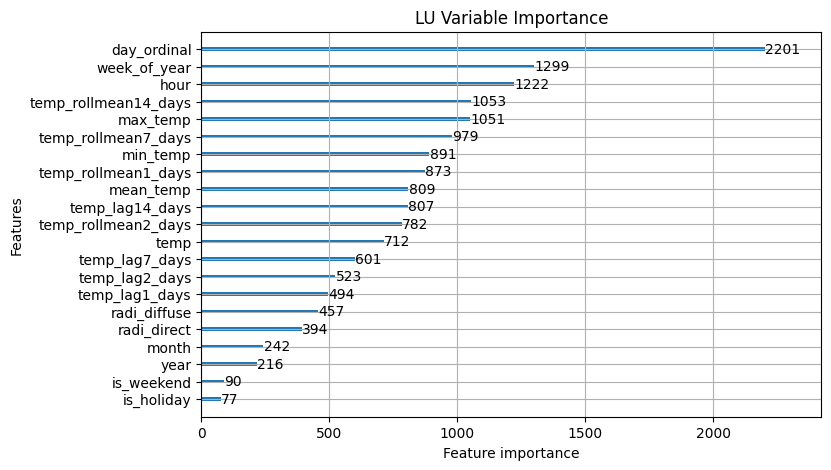

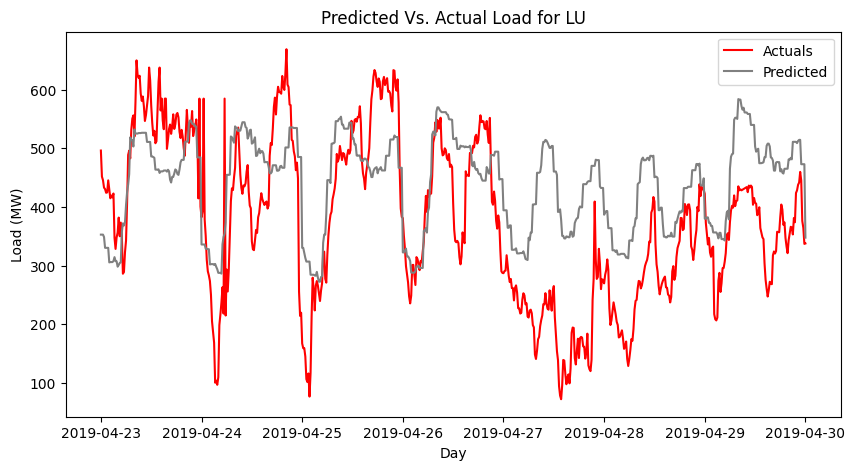

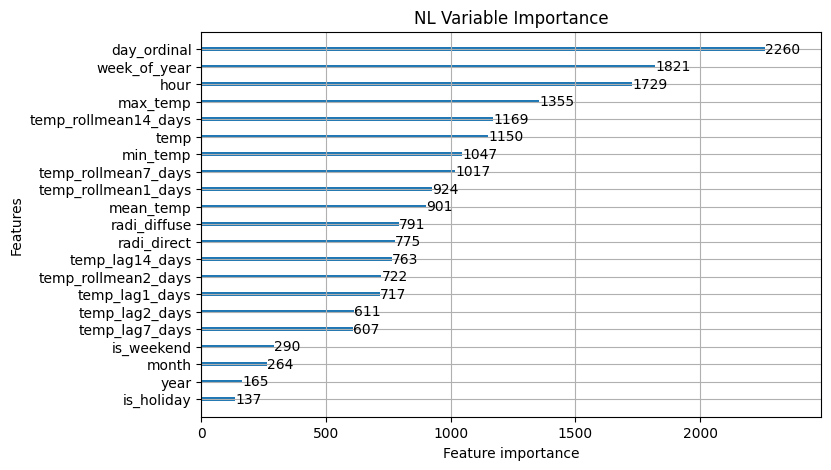

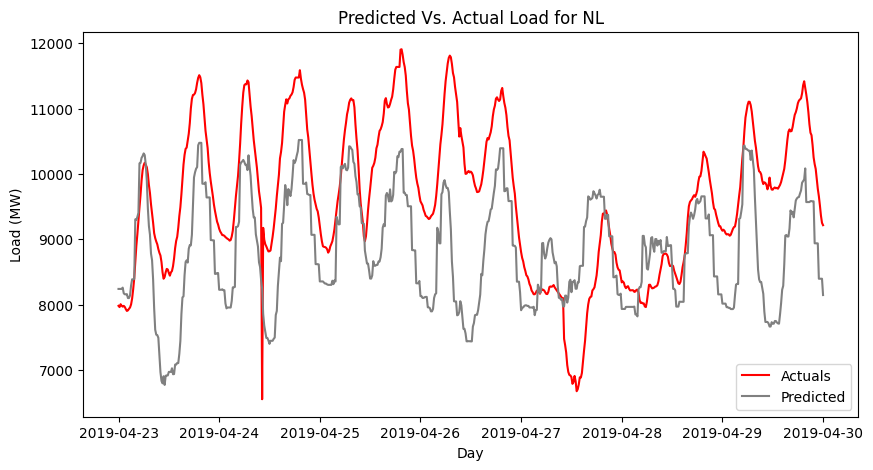

In [27]:
mlflow.end_run()
# automated_forecast(datasets=[Xd, Xu], 
#                    dataset_names=['Xd: downsampled', 'Xu: upsampled'], 
#                    iter_per_model=2, 
#                    experiment_name='Optimized Models by Country: Test')

automated_forecast(data=Xu, 
                   iter_per_model=4, 
                   experiment_name='Upsample only')

[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x000002AD57893800>
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


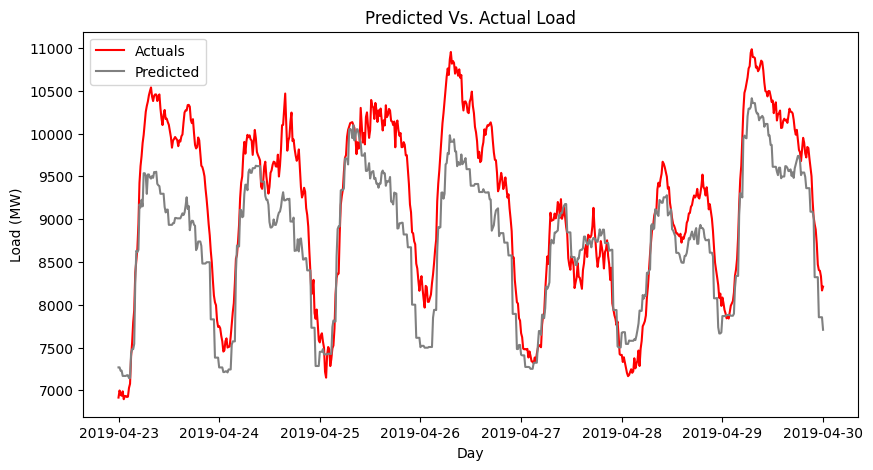

In [ ]:
def hyperparam_opt(params, ts_cv, model):
    mlflow.log_params(params)

    # Optimization params
    #iteration_number = 10 # ------
    opt = BayesSearchCV(
        model,
        params,
        cv=ts_cv,
        n_iter=iteration_number, # 50, 100
        scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=True,
        # keep_training_booster=True,
        optimizer_kwargs = {'base_estimator': 'RF'},
    )

    # Run and time bayesian optimization of params
    start = time.time()
    opt_model = opt.fit(X_train, y_train)
    end = round(time.time() - start, 2)


# function for naming model runs

def model_results():
    # Logging the best params
    mlflow.log_table(opt_model.best_params_, artifact_file='best_params.json')

    # Variable Importance Plot
    importance_plot = lgbm.plot_importance(opt.best_estimator_, figsize=(8,5))
    mlflow.log_figure(importance_plot.figure, 'variable_importance.png') 
    
    # Get predictions of optimal set of params for final test set
    X_test, y_test = country_train_test(final_test_u, drop_index=False)
    y_pred = opt_model.best_estimator_.predict(X_test.drop(columns='utc_timestamp'))
    y_test = np.reshape(y_test, (673,))
    final_mape = mean_absolute_percentage_error(y_test, y_pred)  

    # Time Series plot of Predicted Vs Actuals
    plot_dt = pd.DataFrame({'Day': X_test['utc_timestamp'],
                            'actual': np.reshape(y_test, (673,)),
                            'predicted': y_pred})

    test_plot = plt.figure(figsize=(10,5))
    _ = sbn.lineplot(data=plot_dt, 
                     x='Day', 
                     y='actual', 
                     color='red', 
                     label='Actuals')
    _ = sbn.lineplot(data=plot_dt, 
                     x='Day', 
                     y='predicted', 
                     color='grey', 
                     label='Predicted')
    _ = plt.ylabel('Load (MW)')
    _ = plt.title('Predicted Vs. Actual Load') # 'For {Country}'
    # log time series actual versus predicted
    mlflow.log_figure(test_plot, 'predicted_vs_actuals.png') 
    
    # Record Training Metrics
    mlflow.log_metrics({
            'optimization_iteration_number': iteration_number,
            'training_time': end,
            'best_training_mape': abs(opt.best_score_),
            'final_test_mape': final_mape,
        })

Optimized Model Final Test Set Performance and Visualizations

In [ ]:
### Functionalize model, then run with lags removed from the dataset

Results Graphs (MLflow)

Best Model on final validation set